In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.layers import LSTM
import time
import math

In [45]:
%matplotlib inline

In [3]:
crimedf=pd.read_csv('Baton_Rouge_Crime_Incidents.csv',na_values=['nan'])

/home/mani/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
crimedf.head(5)

,FILE NUMBER,OFFENSE DATE,OFFENSE TIME,CRIME,COMMITTED,OFFENSE,OFFENSE DESC,ADDRESS,ST NUMBER,ST DIR,ST NAME,ST TYPE,CITY,STATE,ZIP,DISTRICT,ZONE,SUBZONE,COMPLETE DISTRICT,GEOLOCATION
0,1.100092e+09,08/29/2011,1430,THEFT,COMMITTED,14:67/AI,THEFT OVER $200 ALL OTHER,1185 COLONIAL DR,1185.0,NaN,COLONIAL,DR,BATON ROUGE,LA,70806,3,G,1,3G1,"1185 COLONIAL DR\nBATON ROUGE, LA 70806\n(30.4..."
1,1.500003e+09,01/11/2015,0210,OTHER,COMMITTED,11:140,D W I /CC,150 S 19TH ST,150.0,S,19TH,ST,BATON ROUGE,LA,NaN,2,A,1,2A1,"150 S 19TH ST\nBATON ROUGE, LA\n(30.447165, -9..."
2,1.700023e+09,03/06/2017,0630,BATTERY,COMMITTED,13:35.3,DOMESTIC ABUSE BATTERY/CC,3484 CEDARCREST AV,3484.0,NaN,CEDARCREST,AV,BATON ROUGE,LA,70816,3,C,3,3C3,"3484 CEDARCREST AV\nBATON ROUGE, LA 70816\n(30..."
3,1.100128e+09,12/09/2011,1450,THEFT,COMMITTED,14:68.4,UNAU USE OF MOTOR VEHICLE,7234 AIRLINE HW,7234.0,NaN,AIRLINE,HW,BATON ROUGE,LA,NaN,1,F,2,1F2,"7234 AIRLINE HW\nBATON ROUGE, LA\n(30.482565, ..."
4,1.600010e+09,01/29/2016,2030,INDIVIDUAL ROBBERY,COMMITTED,14:64/BE,ROBB/BLADE RESIDENCE,9845 BLAKEMORE AV,9845.0,NaN,BLAKEMORE,AV,BATON ROUGE,LA,70802,2,E,4,2E4,"9845 BLAKEMORE AV\nBATON ROUGE, LA 70802\n(30...."


In [5]:
crimedf.shape

(349766, 20)

In [6]:
crimedf=crimedf.drop_duplicates(['OFFENSE DATE','OFFENSE TIME','GEOLOCATION','CRIME','OFFENSE DESC'])
crimedf.shape

(346872, 20)

In [7]:
crimedf=crimedf[crimedf['COMMITTED']=='COMMITTED']
crimedf=crimedf[crimedf['CRIME']=='THEFT']
crimedf.shape

(67637, 20)

In [8]:
crimedf['OFFENSE DATE']=pd.to_datetime(crimedf['OFFENSE DATE'])

In [9]:
crimedf.dropna(subset=['CRIME'],inplace=True)
crimedf.shape

(67637, 20)

In [10]:
crimegroup=crimedf.groupby(pd.Grouper(key='OFFENSE DATE', freq='D')).count()

In [11]:
crimegroup=crimegroup['CRIME']
crimegroup.head(10)

OFFENSE DATE
2011-01-01    57
2011-01-02    19
2011-01-03    21
2011-01-04    24
2011-01-05    29
2011-01-06    27
2011-01-07    26
2011-01-08    24
2011-01-09    17
2011-01-10    30
Freq: D, Name: CRIME, dtype: int64

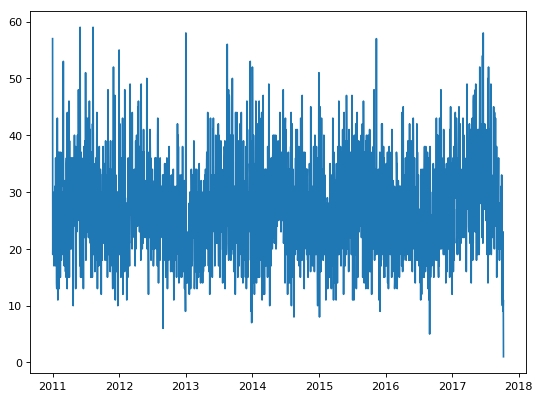

In [12]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(crimegroup)
plt.show()

## Part 1: Time Series Forecasting

In [13]:
np.random.seed(419)

In [14]:
#train=crimegroup[crimegroup.index.year<2016].values
#test=crimegroup[crimegroup.index.year>=2016].values
#print(train[:6])
#print(test[:6])

In [16]:
train, test = train_test_split(crimegroup.values,test_size=0.3,shuffle=False)
print(train[:6])
print(test[:6])

[57 19 21 24 29 27]
[40 36 29 37 23 23]


In [17]:
train=np.reshape(train,(-1,1))
test=np.reshape(test,(-1,1))
print(train[:6])
print(train.shape,test.shape)

[[57]
 [19]
 [21]
 [24]
 [29]
 [27]]
(1731, 1) (743, 1)


In [20]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [22]:
def create_dataset2(dataset,look_back=1):
    dataX, dataY = [], []
    for i in range(look_back,len(dataset)-1):
        a=dataset[i-look_back:i+1,0]
        dataX.append(a)
        dataY.append(dataset[i+1,0])
    return np.array(dataX), np.array(dataY)
    

In [35]:
look_back = 10
trainX, trainY = create_dataset2(train, look_back)
testX, testY = create_dataset2(test, look_back)
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(1720, 11) (1720,) (732, 11) (732,)


In [34]:
np.reshape(trainY,)

TypeError: reshape() takes from 2 to 3 positional arguments but 4 were given

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [36]:
model = Sequential()
model.add(Dense(5, input_dim=look_back+1, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(5))
#model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [37]:
starttime=time.time()
h=model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=1,validation_data=(testX,testY))
endtime=time.time()

Train on 1720 samples, validate on 732 samples
Epoch 1/100
1720/1720 [==============================] - 0s - loss: 129.0365 - acc: 0.0413 - val_loss: 71.0539 - val_acc: 0.0533
Epoch 2/100
1720/1720 [==============================] - 0s - loss: 73.2455 - acc: 0.0488 - val_loss: 67.1451 - val_acc: 0.0574
Epoch 3/100
1720/1720 [==============================] - 0s - loss: 69.4495 - acc: 0.0494 - val_loss: 63.3876 - val_acc: 0.0519
Epoch 4/100
1720/1720 [==============================] - 0s - loss: 68.2262 - acc: 0.0558 - val_loss: 63.6984 - val_acc: 0.0423
Epoch 5/100
1720/1720 [==============================] - 0s - loss: 66.5058 - acc: 0.0605 - val_loss: 67.3507 - val_acc: 0.0546
Epoch 6/100
1720/1720 [==============================] - 0s - loss: 66.1771 - acc: 0.0564 - val_loss: 60.8377 - val_acc: 0.0451
Epoch 7/100
1720/1720 [==============================] - 0s - loss: 65.5615 - acc: 0.0570 - val_loss: 61.5396 - val_acc: 0.0587
Epoch 8/100
1720/1720 [==============================] -

1720/1720 [==============================] - 0s - loss: 60.0447 - acc: 0.0547 - val_loss: 58.3445 - val_acc: 0.0437
Epoch 65/100
1720/1720 [==============================] - 0s - loss: 59.2811 - acc: 0.0488 - val_loss: 59.0729 - val_acc: 0.0560
Epoch 66/100
1720/1720 [==============================] - 0s - loss: 59.7056 - acc: 0.0558 - val_loss: 59.0066 - val_acc: 0.0519
Epoch 67/100
1720/1720 [==============================] - 0s - loss: 59.6860 - acc: 0.0576 - val_loss: 58.7465 - val_acc: 0.0519
Epoch 68/100
1720/1720 [==============================] - 0s - loss: 59.8813 - acc: 0.0517 - val_loss: 58.5976 - val_acc: 0.0451
Epoch 69/100
1720/1720 [==============================] - 0s - loss: 60.3262 - acc: 0.0558 - val_loss: 59.3225 - val_acc: 0.0437
Epoch 70/100
1720/1720 [==============================] - 0s - loss: 59.7640 - acc: 0.0517 - val_loss: 58.3849 - val_acc: 0.0451
Epoch 71/100
1720/1720 [==============================] - 0s - loss: 59.1479 - acc: 0.0465 - val_loss: 59.1402

In [40]:
score=model.evaluate(testX,testY,verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Training time %d' % (endtime-starttime))

Test score: 59.0715394984
Test accuracy: 0.051912568306
Training time 69


0.0616279069767 0.0655737704918 7


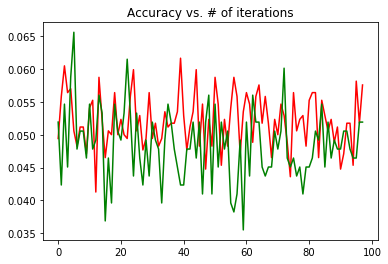

In [183]:
pt = h.history['acc']
pv = h.history['val_acc']
plt.title('Accuracy vs. # of iterations')
plt.plot(pt[2:], 'r',label='training accuracy')
plt.plot(pv[2:], 'g',label='validation accuracy')
print(np.max(pt), np.max(pv), np.argmax(pv))

In [47]:
#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [48]:
trainPredict=trainPredict.reshape(trainPredict.shape[0])
testPredict=testPredict.reshape(testPredict.shape[0])
print(trainPredict.shape,testPredict.shape)

(1720,) (732,)


In [49]:
# calculate root mean squared error
print('Mean squared error')
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
print('Mean Absolute Error')
mapetrain=mean_absolute_error(trainY,trainPredict)
print('Train: %2f MAPE' % (mapetrain))
mapetest=mean_absolute_error(testY,testPredict)
print('Test Score: %.2f MAPSE' % (mapetest))

Mean squared error
Train Score: 7.58 RMSE
Test Score: 7.69 RMSE
Mean Absolute Error
Train: 5.973476 MAPE
Test Score: 6.13 MAPSE


In [50]:
print(testY[0],testPredict[0])

23 27.6159


In [51]:
crimeplot=crimegroup.copy()
trainplot=pd.Series(index=crimeplot.index)
testplot=pd.Series(index=crimeplot.index)
print(len(crimeplot),len(trainplot),len(testplot))
print(len(trainPredict),len(testPredict))

2474 2474 2474
1720 732


In [52]:
trainplot[look_back:len(trainPredict)+look_back]=trainPredict
testplot[len(trainPredict)+(look_back*2)+1:len(crimeplot)-1]=testPredict

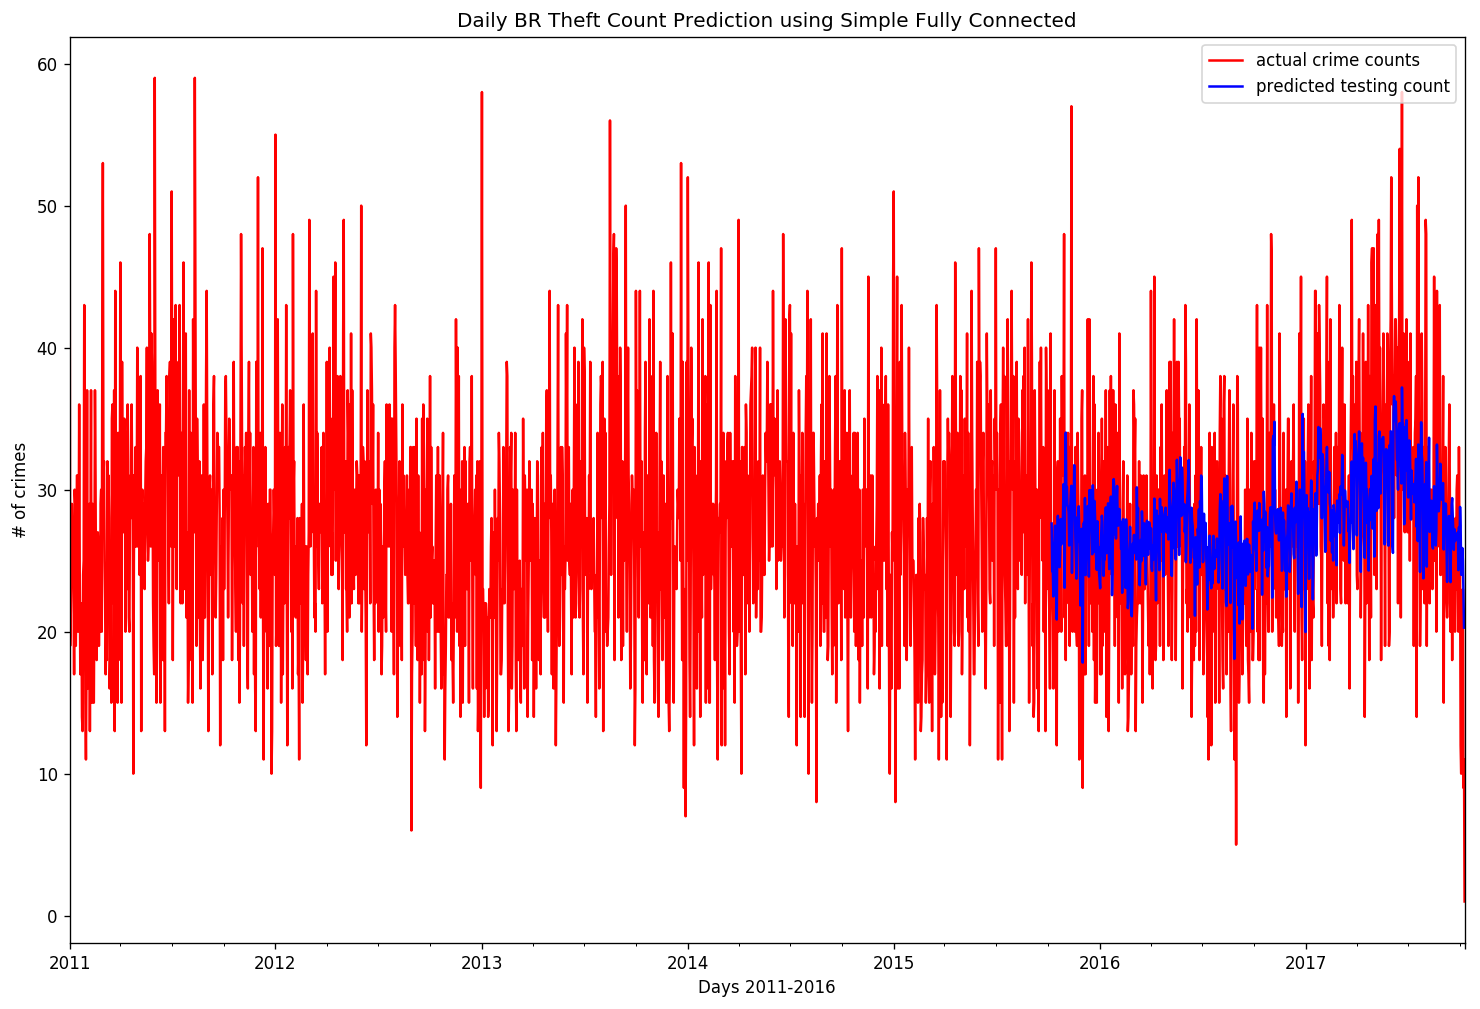

In [54]:
plt.clf()
plt.figure(num=None, figsize=(15, 10), dpi=120, facecolor='w', edgecolor='k')
crimeplot.plot(color='red',label='actual crime counts')
#trainplot.plot(color='green',label='predicted training count')
testplot.plot(color='blue',label='predicted testing count')
plt.title('Daily BR Theft Count Prediction using Simple Fully Connected')
plt.xlabel('Days 2011-2016')
plt.ylabel('# of crimes')
plt.legend(loc='upper right')
plt.show()

# Part 2 testing: LSTM Version

In [146]:
dataset=crimegroup.values
dataset=np.reshape(dataset,(-1,1))

In [147]:
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

/home/mani/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
#train2=dataset[0:1826,:]
#test2=dataset[1826:,:]


In [148]:
train2, test2=train_test_split(dataset,test_size=0.3,shuffle=False)
print(train2.shape,test2.shape)

(1731, 1) (743, 1)


In [107]:
#train2=np.reshape(train,(-1,1))
#test2=np.reshape(test,(-1,1))


In [30]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [149]:
def create_dataset2(dataset,look_back=1):
    dataX, dataY = [], []
    for i in range(look_back,len(dataset)-1):
        a=dataset[i-look_back:i+1,0]
        dataX.append(a)
        dataY.append(dataset[i+1,0])
    return np.array(dataX), np.array(dataY)

In [150]:
look_back2 = 10
train2X, train2Y = create_dataset2(train2, look_back2)
test2X, test2Y = create_dataset2(test2, look_back2)
print(train2X.shape,train2Y.shape,test2X.shape,test2Y.shape)

(1720, 11) (1720,) (732, 11) (732,)


In [151]:
# reshape input to be [samples, time steps, features]
train2X = np.reshape(train2X, (train2X.shape[0], 1, train2X.shape[1]))
test2X = np.reshape(test2X, (test2X.shape[0], 1, test2X.shape[1]))

In [152]:
model2 = Sequential()
model2.add(LSTM(look_back2+1, input_shape=(1, look_back2+1)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [153]:
starttime2=time.time()
h2=model2.fit(train2X, train2Y, epochs=100, batch_size=2, verbose=2)
endtime2=time.time()

Epoch 1/100
1s - loss: 0.0227 - acc: 0.0000e+00
Epoch 2/100
1s - loss: 0.0185 - acc: 0.0000e+00
Epoch 3/100
1s - loss: 0.0183 - acc: 0.0000e+00
Epoch 4/100
1s - loss: 0.0181 - acc: 5.8140e-04
Epoch 5/100
1s - loss: 0.0180 - acc: 0.0000e+00
Epoch 6/100
1s - loss: 0.0181 - acc: 0.0000e+00
Epoch 7/100
1s - loss: 0.0180 - acc: 0.0000e+00
Epoch 8/100
1s - loss: 0.0180 - acc: 0.0000e+00
Epoch 9/100
1s - loss: 0.0180 - acc: 0.0000e+00
Epoch 10/100
1s - loss: 0.0180 - acc: 0.0000e+00
Epoch 11/100
1s - loss: 0.0179 - acc: 0.0000e+00
Epoch 12/100
1s - loss: 0.0178 - acc: 0.0000e+00
Epoch 13/100
1s - loss: 0.0179 - acc: 0.0000e+00
Epoch 14/100
1s - loss: 0.0180 - acc: 0.0000e+00
Epoch 15/100
1s - loss: 0.0180 - acc: 0.0000e+00
Epoch 16/100
1s - loss: 0.0179 - acc: 5.8140e-04
Epoch 17/100
1s - loss: 0.0179 - acc: 0.0000e+00
Epoch 18/100
1s - loss: 0.0178 - acc: 0.0000e+00
Epoch 19/100
1s - loss: 0.0180 - acc: 0.0000e+00
Epoch 20/100
1s - loss: 0.0180 - acc: 0.0000e+00
Epoch 21/100
1s - loss: 0.017

In [154]:
score2=model2.evaluate(test2X,test2Y,verbose=0)
print('Test score:', score2[0])
print('Test accuracy:', score2[1])
print('Training time %d' % (endtime2-starttime2))

Test score: 0.0188213838621
Test accuracy: 0.00136612027965
Training time 112


0.000581395348837 0.0655737704918 7


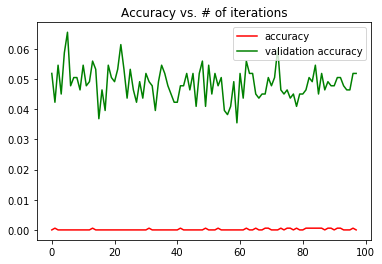

In [185]:
pt2 = h2.history['acc']
pv2 = h.history['val_acc']
plt.plot(pt2[2:], 'r',label='accuracy')
plt.plot(pv2[2:], 'g',label='validation accuracy')
plt.title('Accuracy vs. # of iterations')
plt.legend(loc='upper right')
print(np.max(pt2), np.max(pv2), np.argmax(pv2))

In [156]:
#make predictions
train2Predict = model2.predict(train2X)
test2Predict = model2.predict(test2X)
print(train2Predict.shape,train2Y.shape)

(1720, 1) (1720,)


In [139]:
# invert predictions
#train2Yinv=train2Y.reshape(-1,1)
#test2Yinv=test2Y.reshape(-1,1)
#print(train2Yinv.shape,test2Yinv.shape)

(1720, 1) (732, 1)


In [157]:
#inverse transform predictions
train2Predictinv = scaler.inverse_transform(train2Predict)
train2Yinv = scaler.inverse_transform([train2Y])
test2Predictinv = scaler.inverse_transform(test2Predict)
test2Yinv = scaler.inverse_transform([test2Y])

In [158]:
# calculate root mean squared error
print('Mean squared error')
train2Score = math.sqrt(mean_squared_error(train2Yinv[0], train2Predictinv[:,0]))
print('Train Score: %.2f RMSE' % (train2Score))
test2Score = math.sqrt(mean_squared_error(test2Yinv[0], test2Predictinv[:,0]))
print('Test Score: %.2f RMSE' % (test2Score))
print('Mean Absolute Error')
mape2train=mean_absolute_error(train2Yinv[0],train2Predictinv[:,0])
print('Train: %2f MAPE' % (mape2train))
mape2test=mean_absolute_error(test2Yinv[0],test2Predictinv[:,0])
print('Test Score: %.2f MAPSE' % (mape2test))

Mean squared error
Train Score: 7.50 RMSE
Test Score: 7.96 RMSE
Mean Absolute Error
Train: 5.857063 MAPE
Test Score: 6.30 MAPSE


In [165]:
print(train2Y.shape,train2Predict.shape)
train2Predictinv=train2Predictinv.reshape(train2Predictinv.shape[0])
test2Predictinv=test2Predictinv.reshape(test2Predictinv.shape[0])

(1720,) (1720,)


In [170]:
train2plot=pd.Series(index=crimeplot.index)
test2plot=pd.Series(index=crimeplot.index)
train2plot[look_back2:len(train2Predictinv)+look_back2]=train2Predictinv
test2plot[len(train2Predictinv)+(look_back2*2)+1:len(crimeplot)-1]=test2Predictinv

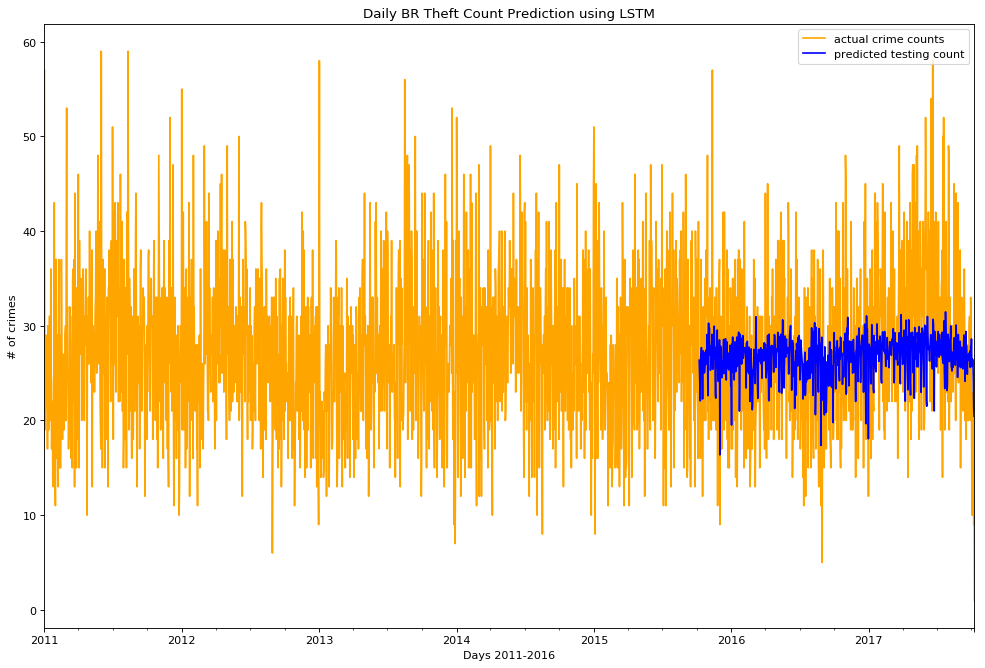

In [171]:
plt.clf()
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
crimeplot.plot(color='orange',label='actual crime counts')
#train2plot.plot(color='purple',label='predicted training count')
test2plot.plot(color='blue',label='predicted testing count')
plt.title('Daily BR Theft Count Prediction using LSTM')
plt.xlabel('Days 2011-2016')
plt.ylabel('# of crimes')
plt.legend(loc='upper right')
plt.show()

## Part 3: ARIMA

In [127]:
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

/home/mani/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


/home/mani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


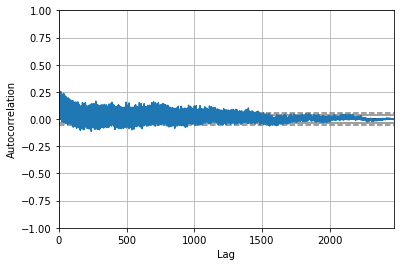

In [128]:
autocorrelation_plot(crimegroup)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.show()

In [129]:
crimegroup.dtype
acrimegroup=crimegroup.astype(np.float64)

In [130]:
#fit ARIMA model to crime series
look_back3=10
amodel=ARIMA(acrimegroup,order=(look_back3,1,0))
amodel_fit=amodel.fit(disp=0)
print(amodel_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.CRIME   No. Observations:                 2473
Model:                ARIMA(10, 1, 0)   Log Likelihood               -8613.067
Method:                       css-mle   S.D. of innovations              7.874
Date:                Sun, 05 Nov 2017   AIC                          17250.133
Time:                        04:52:09   BIC                          17319.891
Sample:                    01-02-2011   HQIC                         17275.473
                         - 10-09-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0068      0.028     -0.247      0.805      -0.061       0.047
ar.L1.D.CRIME     -0.8549      0.020    -42.402      0.000      -0.894      -0.815
ar.L2.D.CRIME     -0.8020      0.026

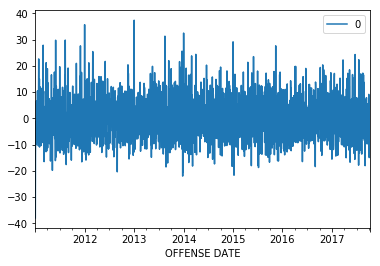

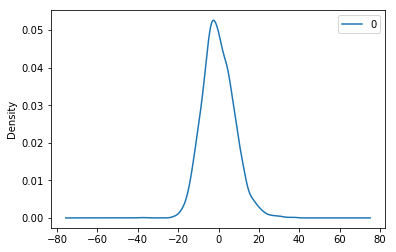

                 0
count  2473.000000
mean     -0.024552
std       7.894093
min     -37.993172
25%      -5.341314
50%      -0.625645
75%       4.936463
max      37.425717


In [131]:
#plot residual errors
residuals=pd.DataFrame(amodel_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [184]:
X=acrimegroup.values
p=5
size=int(len(X)*0.70)
atrain, atest=X[0:size],X[size:len(X)]
history=[x for x in atrain]
predictions=list()
starttime3=time.time()
for t in range(len(atest)):
    amodel=ARIMA(history,order=(p,1,0))
    amodel_fit=amodel.fit(disp=0)
    output=amodel_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=atest[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
endtime3=time.time()
error=math.sqrt(mean_squared_error(atest,predictions))
maperror=mean_absolute_error(atest,predictions)
print('Training Time: %d' %(endtime3-starttime3))
print('Test RMSE: %.3f' % error)
print('Test MAPE: %.3f' % maperror)


KeyboardInterrupt: 

In [176]:
atest.shape

(743,)

In [177]:
arimaplot=pd.Series(index=crimeplot.index)
arimaplot[len(crimeplot)-len(predictions):]=predictions

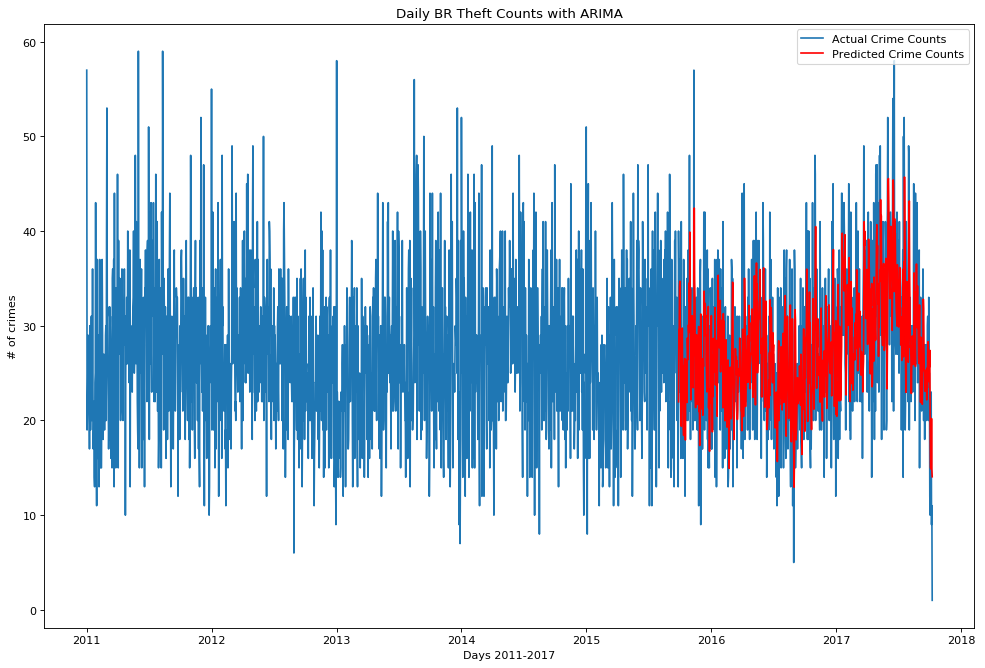

In [178]:
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(crimeplot, label='Actual Crime Counts')
plt.plot(arimaplot,color='red',label='Predicted Crime Counts')
plt.title('Daily BR Theft Counts with ARIMA')
plt.xlabel('Days 2011-2017')
plt.ylabel('# of crimes')
plt.legend(loc='upper right')
plt.show()